In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install transformers==4.16
%pip install arabert
%pip install farasapy
%pip install pyarabic==0.6.14
%pip install sentencepiece==0.1.96

In [9]:
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

In [10]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map


    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

## Data Preprocessing and Translating

In [ ]:
# ar_ht_en_tune = open('Arab-Acquis/Arabic-Translations/tune.en_ref.ar').read().splitlines()
# ar_ht_en_dev = open('Arab-Acquis/Arabic-Translations/dev.en_ref.ar').read().splitlines()

# ar_ht_fr_tune = open('Arab-Acquis/Arabic-Translations/tune.fr_ref.ar').read().splitlines()
# ar_ht_fr_dev = open('Arab-Acquis/Arabic-Translations/dev.fr_ref.ar').read().splitlines()


In [ ]:
# get the arabic sentences from the dataset (HT)
# ar_ht_en_tune = pd.DataFrame(ar_ht_en_tune, columns=['sentences'])

# ar_ht_en_dev = pd.DataFrame(ar_ht_en_dev, columns=['sentences'])


# ar_ht_fr_tune = pd.DataFrame(ar_ht_fr_tune, columns=['sentences'])

# ar_ht_fr_dev = pd.DataFrame(ar_ht_fr_dev, columns=['sentences'])

In [ ]:
# get english and french data to translate
# en_tune = open('Arab-Acquis/JRC-Acquis/ac-dev.en').read().splitlines()
# en_dev = open('Arab-Acquis/JRC-Acquis/ac-devtest.en').read().splitlines()

# fr_tune = open('Arab-Acquis/JRC-Acquis/ac-dev.fr').read().splitlines()
# fr_dev = open('Arab-Acquis/JRC-Acquis/ac-devtest.fr').read().splitlines()

In [ ]:
# %pip install googletrans==4.0.0rc1
# %pip install -U deep-translator

In [ ]:
from googletrans import Translator
translator = Translator()
from deep_translator import GoogleTranslator
deep_translator = GoogleTranslator(source='fr', target='ar')

#googletrans stopped working (API issues) so I used deep_translator instead

In [ ]:
# translate to arabic
ar_mt_en_tune = []
for i in range(len(en_tune)):
    ar_mt_en_tune.append(deep_translator.translate(en_tune[i]))

ar_mt_en_dev = []
for i in range(len(en_dev)):
    ar_mt_en_dev.append(deep_translator.translate(en_dev[i]))

ar_mt_fr_tune = []
for i in range(len(fr_tune)):
    ar_mt_fr_tune.append(deep_translator.translate(fr_tune[i]))

ar_mt_fr_dev = []
for i in range(len(fr_dev)):
    ar_mt_fr_dev.append(deep_translator.translate(fr_dev[i]))

In [ ]:
# make dataframes
ar_en_tune = pd.DataFrame({'en': en_tune, 'ar_mt': ar_mt_en_tune, 'ar_ht': ar_ht_en_tune})
ar_en_dev = pd.DataFrame({'en': en_dev, 'ar_mt': ar_mt_en_dev, 'ar_ht': ar_ht_en_dev})
ar_fr_tune = pd.DataFrame({'fr': fr_tune, 'ar_mt': ar_mt_fr_tune, 'ar_ht': ar_ht_fr_tune})
ar_fr_dev = pd.DataFrame({'fr': fr_dev, 'ar_mt': ar_mt_fr_dev, 'ar_ht': ar_ht_fr_dev})


In [ ]:
#delete repeated english/french rows
ar_en_tune = ar_en_tune.drop_duplicates(subset=['en'])
ar_en_dev = ar_en_dev.drop_duplicates(subset=['en'])
ar_fr_tune = ar_fr_tune.drop_duplicates(subset=['fr'])
ar_fr_dev = ar_fr_dev.drop_duplicates(subset=['fr'])

#delete the rows where mt is the same as ht
ar_en_tune = ar_en_tune[ar_en_tune['ar_mt'] != ar_en_tune['ar_ht']]
ar_en_dev = ar_en_dev[ar_en_dev['ar_mt'] != ar_en_dev['ar_ht']]
ar_fr_tune = ar_fr_tune[ar_fr_tune['ar_mt'] != ar_fr_tune['ar_ht']]
ar_fr_dev = ar_fr_dev[ar_fr_dev['ar_mt'] != ar_fr_dev['ar_ht']]

In [ ]:
#save the dataframes
ar_en_tune.to_csv('ar_en_tune_filtered.csv', index=False)
ar_en_dev.to_csv('ar_en_dev_filtered.csv', index=False)
ar_fr_tune.to_csv('ar_fr_tune_filtered.csv', index=False)
ar_fr_dev.to_csv('ar_fr_dev_filterd.csv', index=False)


## Hyperparameter Tuning

In [4]:
#import data
ar_en_tune = pd.read_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/ar_en_tune_filtered.csv')
ar_en_dev = pd.read_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/ar_en_dev_filtered.csv')
ar_fr_tune = pd.read_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/ar_fr_tune_filtered.csv')
ar_fr_dev = pd.read_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/ar_fr_dev_filterd.csv')

In [ ]:
## combine tune and dev and split into train and dev 20%
ar_en = pd.concat([ar_en_tune, ar_en_dev])
ar_fr = pd.concat([ar_fr_tune, ar_fr_dev])

from sklearn.model_selection import train_test_split
ar_en_train, ar_en_dev = train_test_split(ar_en, test_size=0.2, random_state=42)
ar_fr_train, ar_fr_dev = train_test_split(ar_fr, test_size=0.2, random_state=42)

In [12]:
len(ar_en_train), len(ar_en_dev), len(ar_fr_train), len(ar_fr_dev)

NameError: ignored

In [13]:
#import and define arabert preprocessor
from arabert.preprocess import ArabertPreprocessor
# model_name = 'aubmindlab/bert-base-arabertv2'
model_name = 'aubmindlab/bert-base-arabertv2'
arabic_prep = ArabertPreprocessor(model_name)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


100%|██████████| 241M/241M [00:25<00:00, 9.62MiB/s]


[2023-11-24 08:00:21,100 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
#
tok = AutoTokenizer.from_pretrained(model_name)

In [15]:
max_len = 160
label_map = {0: 0, 1: 1}
train_dataset = ClassificationDataset(
    np.concatenate((ar_en_train['ar_ht'], ar_en_train['ar_mt'], ar_fr_train['ar_ht'], ar_fr_train['ar_mt']), axis=0).tolist(),
    np.concatenate((np.zeros(len(ar_en_train)), np.ones(len(ar_en_train)), np.zeros(len(ar_fr_train)), np.ones(len(ar_fr_train))), axis=0).tolist(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    np.concatenate((ar_en_dev['ar_ht'], ar_en_dev['ar_mt'], ar_fr_dev['ar_ht'], ar_fr_dev['ar_mt']), axis=0).tolist(),
    np.concatenate((np.zeros(len(ar_en_dev)), np.ones(len(ar_en_dev)), np.zeros(len(ar_fr_dev)), np.ones(len(ar_fr_dev))), axis=0).tolist(),
    model_name,
    max_len,
    label_map
  )

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=2)

In [ ]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  print(classification_report(p.label_ids,preds))
  print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  macro_precision = precision_score(p.label_ids,preds,average='macro')
  macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {
      'macro_f1' : macro_f1,
      'accuracy': acc,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall
  }

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

### Learning Rate

In [ ]:
#lr = 1e-5

In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1",
    adam_epsilon = 1e-8,
    learning_rate = 1e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 4,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20230
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2528


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
0,0.564800,0.448688,0.777609,0.778261,0.781563,0.778261
1,0.449000,0.399578,0.799970,0.800791,0.805806,0.800791
2,0.383000,0.410585,0.804920,0.806719,0.818471,0.806719
3,0.313800,0.399233,0.812511,0.813439,0.819770,0.813439


***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.81      0.72      0.77      2530
           1       0.75      0.83      0.79      2530

    accuracy                           0.78      5060
   macro avg       0.78      0.78      0.78      5060
weighted avg       0.78      0.78      0.78      5060

[[1832  698]
 [ 424 2106]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-632
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-632/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-632/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.84      0.74      0.79      2530
           1       0.77      0.86      0.81      2530

    accuracy                           0.80      5060
   macro avg       0.81      0.80      0.80      5060
weighted avg       0.81      0.80      0.80      5060

[[1864  666]
 [ 342 2188]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-1264
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-1264/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-1264/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.88      0.71      0.79      2530
           1       0.76      0.90      0.82      2530

    accuracy                           0.81      5060
   macro avg       0.82      0.81      0.80      5060
weighted avg       0.82      0.81      0.80      5060

[[1798  732]
 [ 246 2284]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-1896
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-1896/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-1896/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.86      0.74      0.80      2530
           1       0.77      0.88      0.83      2530

    accuracy                           0.81      5060
   macro avg       0.82      0.81      0.81      5060
weighted avg       0.82      0.81      0.81      5060

[[1880  650]
 [ 294 2236]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-2528
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-2528/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-2528/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr1/checkpoint-2528 (score: 0.8125106763532592).


TrainOutput(global_step=2528, training_loss=0.4100747746002825, metrics={'train_runtime': 2199.4256, 'train_samples_per_second': 36.791, 'train_steps_per_second': 1.149, 'total_flos': 6652927479187200.0, 'train_loss': 0.4100747746002825, 'epoch': 4.0})

In [ ]:
#lr = 2e-5
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 4,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20230
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2528


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
0,0.531500,0.425188,0.796691,0.796838,0.797698,0.796838
1,0.396900,0.370225,0.821578,0.821739,0.822905,0.821739
2,0.317900,0.380415,0.829076,0.830040,0.837657,0.830040
3,0.230100,0.394040,0.836347,0.836759,0.840188,0.836759


***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2530
           1       0.81      0.77      0.79      2530

    accuracy                           0.80      5060
   macro avg       0.80      0.80      0.80      5060
weighted avg       0.80      0.80      0.80      5060

[[2084  446]
 [ 582 1948]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-632
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-632/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-632/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.84      0.79      0.82      2530
           1       0.80      0.85      0.83      2530

    accuracy                           0.82      5060
   macro avg       0.82      0.82      0.82      5060
weighted avg       0.82      0.82      0.82      5060

[[2003  527]
 [ 375 2155]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-1264
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-1264/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-1264/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.89      0.75      0.82      2530
           1       0.79      0.91      0.84      2530

    accuracy                           0.83      5060
   macro avg       0.84      0.83      0.83      5060
weighted avg       0.84      0.83      0.83      5060

[[1910  620]
 [ 240 2290]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-1896
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-1896/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-1896/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.87      0.79      0.83      2530
           1       0.81      0.89      0.84      2530

    accuracy                           0.84      5060
   macro avg       0.84      0.84      0.84      5060
weighted avg       0.84      0.84      0.84      5060

[[1990  540]
 [ 286 2244]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-2528
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-2528/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-2528/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr2/checkpoint-2528 (score: 0.8363465189276169).


TrainOutput(global_step=2528, training_loss=0.3478207041191149, metrics={'train_runtime': 854.811, 'train_samples_per_second': 94.664, 'train_steps_per_second': 2.957, 'total_flos': 6652927479187200.0, 'train_loss': 0.3478207041191149, 'epoch': 4.0})

In [ ]:
#lr = 3e-5
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3",
    adam_epsilon = 1e-8,
    learning_rate = 3e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 4,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading weights file https://huggingface.co/aubmindlab/bert-base-arabertv

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20230
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2528


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
0,0.525400,0.424446,0.793108,0.793281,0.794261,0.793281
1,0.398500,0.363673,0.823239,0.823518,0.825573,0.823518
2,0.307300,0.379270,0.831924,0.832609,0.838120,0.832609
3,0.204700,0.403617,0.838886,0.839328,0.843092,0.839328


***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.78      0.82      0.80      2530
           1       0.81      0.76      0.79      2530

    accuracy                           0.79      5060
   macro avg       0.79      0.79      0.79      5060
weighted avg       0.79      0.79      0.79      5060

[[2080  450]
 [ 596 1934]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-632
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-632/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-632/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.85      0.78      0.82      2530
           1       0.80      0.86      0.83      2530

    accuracy                           0.82      5060
   macro avg       0.83      0.82      0.82      5060
weighted avg       0.83      0.82      0.82      5060

[[1983  547]
 [ 346 2184]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-1264
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-1264/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-1264/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.88      0.77      0.82      2530
           1       0.79      0.90      0.84      2530

    accuracy                           0.83      5060
   macro avg       0.84      0.83      0.83      5060
weighted avg       0.84      0.83      0.83      5060

[[1945  585]
 [ 262 2268]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-1896
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-1896/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-1896/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.88      0.79      0.83      2530
           1       0.81      0.89      0.85      2530

    accuracy                           0.84      5060
   macro avg       0.84      0.84      0.84      5060
weighted avg       0.84      0.84      0.84      5060

[[1991  539]
 [ 274 2256]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-2528
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-2528/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-2528/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3/checkpoint-2528 (score: 0.8388861636975136).


TrainOutput(global_step=2528, training_loss=0.3366475158099887, metrics={'train_runtime': 855.9483, 'train_samples_per_second': 94.538, 'train_steps_per_second': 2.953, 'total_flos': 6652927479187200.0, 'train_loss': 0.3366475158099887, 'epoch': 4.0})

In [ ]:
#lr = 5e-5
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr5",
    adam_epsilon = 1e-8,
    learning_rate = 5e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 4,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading weights file https://huggingface.co/aubmindlab/bert-base-arabertv

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20230
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 2528


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
0,0.703500,0.699528,0.333333,0.500000,0.250000,0.500000
1,0.702600,0.693183,0.333333,0.500000,0.250000,0.500000


***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2530
           1       0.00      0.00      0.00      2530

    accuracy                           0.50      5060
   macro avg       0.25      0.50      0.33      5060
weighted avg       0.25      0.50      0.33      5060

[[2530    0]
 [2530    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2530
           1       0.00      0.00      0.00      2530

    accuracy                           0.50      5060
   macro avg       0.25      0.50      0.33      5060
weighted avg       0.25      0.50      0.33      5060

[[2530    0]
 [2530    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

KeyboardInterrupt: ignored

### Batch Size

In [ ]:
#lr = 3e-5
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64",
    adam_epsilon = 1e-8,
    learning_rate = 5e-5,
    fp16 = True, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 64, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 4,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading weights file https://huggingface.co/aubmindlab/bert-base-arabertv

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20230
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 2
  Total optimization steps = 632


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
0,No log,0.413399,0.793102,0.793874,0.798324,0.793874
1,No log,0.368295,0.819969,0.820158,0.821509,0.820158
2,No log,0.376949,0.831510,0.832411,0.839676,0.832411
3,0.381000,0.391117,0.835410,0.836166,0.842460,0.836166


***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.83      0.73      0.78      2530
           1       0.76      0.85      0.81      2530

    accuracy                           0.79      5060
   macro avg       0.80      0.79      0.79      5060
weighted avg       0.80      0.79      0.79      5060

[[1854  676]
 [ 367 2163]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-158
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-158/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-158/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.84      0.79      0.81      2530
           1       0.80      0.85      0.83      2530

    accuracy                           0.82      5060
   macro avg       0.82      0.82      0.82      5060
weighted avg       0.82      0.82      0.82      5060

[[1993  537]
 [ 373 2157]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-316
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-316/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-316/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.89      0.76      0.82      2530
           1       0.79      0.91      0.84      2530

    accuracy                           0.83      5060
   macro avg       0.84      0.83      0.83      5060
weighted avg       0.84      0.83      0.83      5060

[[1921  609]
 [ 239 2291]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-474
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-474/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-474/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.89      0.77      0.82      2530
           1       0.80      0.90      0.85      2530

    accuracy                           0.84      5060
   macro avg       0.84      0.84      0.84      5060
weighted avg       0.84      0.84      0.84      5060

[[1944  586]
 [ 243 2287]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-632
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-632/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-632/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs64/checkpoint-632 (score: 0.8354097125902815).


TrainOutput(global_step=632, training_loss=0.3454498550559901, metrics={'train_runtime': 676.7653, 'train_samples_per_second': 119.569, 'train_steps_per_second': 0.934, 'total_flos': 6652927479187200.0, 'train_loss': 0.3454498550559901, 'epoch': 4.0})

### Number of Epochs

In [ ]:
#load the best model
best_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-2528", return_dict=True)
best_model.config.label2id = label_map
best_model.config.id2label = label_map

#get the hyperparameters of the best model
best_model.config


loading configuration file /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-2528/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-2528",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.16.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading weights file /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16

BertConfig {
  "_name_or_path": "/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-2528",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": 0,
    "1": 1
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": 0,
    "1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.16.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

In [ ]:

training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16",
    adam_epsilon = 1e-8,
    learning_rate = 3e-5,
    fp16 = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 5,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

set_seed(training_args.seed)

trainer = Trainer(
    model = best_model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
  )

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20230
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 3160


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
0,0.253300,0.371263,0.839912,0.839921,0.839998,0.839921
1,0.208600,0.400368,0.848550,0.848617,0.849230,0.848617
2,0.158800,0.448430,0.847351,0.847431,0.848163,0.847431
3,0.105000,0.546589,0.860069,0.860079,0.860178,0.860079
4,0.075000,0.621424,0.857061,0.857312,0.859839,0.857312


***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2530
           1       0.83      0.85      0.84      2530

    accuracy                           0.84      5060
   macro avg       0.84      0.84      0.84      5060
weighted avg       0.84      0.84      0.84      5060

[[2106  424]
 [ 386 2144]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-632
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-632/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-632/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2530
           1       0.83      0.87      0.85      2530

    accuracy                           0.85      5060
   macro avg       0.85      0.85      0.85      5060
weighted avg       0.85      0.85      0.85      5060

[[2094  436]
 [ 330 2200]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-1264
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-1264/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-1264/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.86      0.82      0.84      2530
           1       0.83      0.87      0.85      2530

    accuracy                           0.85      5060
   macro avg       0.85      0.85      0.85      5060
weighted avg       0.85      0.85      0.85      5060

[[2086  444]
 [ 328 2202]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-1896
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-1896/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-1896/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2530
           1       0.85      0.87      0.86      2530

    accuracy                           0.86      5060
   macro avg       0.86      0.86      0.86      5060
weighted avg       0.86      0.86      0.86      5060

[[2155  375]
 [ 333 2197]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-2528
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-2528/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-2528/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 5060
  Batch size = 128


              precision    recall  f1-score   support

           0       0.89      0.82      0.85      2530
           1       0.83      0.90      0.86      2530

    accuracy                           0.86      5060
   macro avg       0.86      0.86      0.86      5060
weighted avg       0.86      0.86      0.86      5060

[[2063  467]
 [ 255 2275]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-3160
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-3160/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-3160/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/MyDrive/AI701/Classifying_Translationese/20-11/lr3bs16/checkpoint-2528 (score: 0.8600694106469552).


TrainOutput(global_step=3160, training_loss=0.15114933176885678, metrics={'train_runtime': 1073.6471, 'train_samples_per_second': 94.212, 'train_steps_per_second': 2.943, 'total_flos': 8316282682291200.0, 'train_loss': 0.15114933176885678, 'epoch': 5.0})

# Load Test Data and Evaluate

## Preprocessing Test Data

In [ ]:
# load test data and evaluate

# ar_ht_en_test = open('/content/drive/MyDrive/AI701/Classifying_Translationese/data/test.en_ref.ar').read().splitlines()
# ar_ht_fr_test = open('/content/drive/MyDrive/AI701/Classifying_Translationese/data/test.fr_ref.ar').read().splitlines()

# #load french and english data to translate
# en_test = open('/content/drive/MyDrive/AI701/Classifying_Translationese/data/ac-test.en').read().splitlines()
# fr_test = open('/content/drive/MyDrive/AI701/Classifying_Translationese/data/ac-test.fr').read().splitlines()

In [ ]:
# from googletrans import Translator
# translator = Translator()
# from deep_translator import GoogleTranslator
# deep_translator_fr = GoogleTranslator(source = 'fr', target = 'ar')
# deep_translator_en = GoogleTranslator(source = 'en', target = 'ar')

In [ ]:
# #translate to arabic in batches
# traslations = []
# n = len(en_test)//100
# for i in range(n):
#   traslations.append(deep_translator_en.translate_batch(en_test[i*100:(i+1)*100]))
# traslations.append(deep_translator_en.translate_batch(en_test[n*100:], source='en', target='ar'))
# ar_mt_en_test = [item for sublist in traslations for item in sublist]

# traslations = []
# n = len(fr_test)//100
# for i in range(n):
#   traslations.append(deep_translator_fr.translate_batch(fr_test[i*100:(i+1)*100]))
# traslations.append(deep_translator_fr.translate_batch(fr_test[n*100:]))
# ar_mt_fr_test = [item for sublist in traslations for item in sublist]

In [ ]:
# ## make one dataframe for english and the corresponding machine and human translations
# ar_en_test = pd.DataFrame({'en': en_test, 'ar_mt': ar_mt_en_test, 'ar_ht': ar_ht_en_test})

# #remove english duplicates
# ar_en_test = ar_en_test.drop_duplicates(subset=['en'])

# #filter rows where mt is the same as ht
# ar_en_test = ar_en_test[ar_en_test['ar_mt'] != ar_en_test['ar_ht']]

# ## make one dataframe for french and the corresponding machine and human translations
# ar_fr_test = pd.DataFrame({'fr': fr_test, 'ar_mt': ar_mt_fr_test, 'ar_ht': ar_ht_fr_test})

# #remove french duplicates
# ar_fr_test = ar_fr_test.drop_duplicates(subset=['fr'])

# #filter rows where mt is the same as ht
# ar_fr_test = ar_fr_test[ar_fr_test['ar_mt'] != ar_fr_test['ar_ht']]

In [ ]:
# ar_en_test.to_csv('ar_en_test.csv')
# ar_fr_test.to_csv('ar_fr_test.csv')

## Load And Evaluate

In [23]:
ar_en_test = pd.read_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/ar_en_test.csv')
ar_fr_test = pd.read_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/ar_fr_test.csv')

In [31]:
# len(ar_fr_test)
np.mean(ar_fr_test['ar_ht'].apply(lambda x: len(x.split())))

27.96450079239303

In [ ]:
test_dataset = ClassificationDataset(
    np.concatenate((ar_en_test['ar_ht'], ar_en_test['ar_mt'], ar_fr_test['ar_ht'], ar_fr_test['ar_mt']), axis=0).tolist(),
    np.concatenate((np.zeros(len(ar_en_test)), np.ones(len(ar_en_test)), np.zeros(len(ar_fr_test)), np.ones(len(ar_fr_test))), axis=0).tolist(),
    model_name,
    max_len,
    label_map
  )

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolv

In [ ]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
print(classification_report(predictions.label_ids,preds))

***** Running Prediction *****
  Num examples = 12530
  Batch size = 128


              precision    recall  f1-score   support

           0       0.83      0.81      0.82      6265
           1       0.81      0.83      0.82      6265

    accuracy                           0.82     12530
   macro avg       0.82      0.82      0.82     12530
weighted avg       0.82      0.82      0.82     12530

[[5054 1211]
 [1047 5218]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      6265
           1       0.81      0.83      0.82      6265

    accuracy                           0.82     12530
   macro avg       0.82      0.82      0.82     12530
weighted avg       0.82      0.82      0.82     12530



In [ ]:
predictions['source_lang'] = np.concatenate((['en'] * (2*len(ar_en_test)), ['fr'] * (2*len(ar_fr_test))), axis =0)

In [ ]:
predictions.to_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/predictions_on_test.csv')

# Train Model on all English data then evaluate on French

In [ ]:
train_dataset = ClassificationDataset(
    np.concatenate((ar_en['ar_ht'], ar_en['ar_mt']), axis=0).tolist(),
    np.concatenate((np.zeros(len(ar_en)), np.ones(len(ar_en))), axis=0).tolist(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    np.concatenate((ar_fr_test['ar_ht'], ar_fr_test['ar_mt']), axis=0).tolist(),
    np.concatenate((np.zeros(len(ar_fr_test)), np.ones(len(ar_fr_test))), axis=0).tolist(),
    model_name,
    max_len,
    label_map
  )

In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/AI701/Classifying_Translationese/all_en_model",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

set_seed(training_args.seed)

In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12636
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 2
  Total optimization steps = 198


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
1,No log,0.739956,0.569168,0.574485,0.578353,0.574485
2,No log,0.822659,0.569982,0.578288,0.584844,0.578288


***** Running Evaluation *****
  Num examples = 6310
  Batch size = 128


              precision    recall  f1-score   support

           0       0.56      0.69      0.62      3155
           1       0.60      0.46      0.52      3155

    accuracy                           0.57      6310
   macro avg       0.58      0.57      0.57      6310
weighted avg       0.58      0.57      0.57      6310

[[2163  992]
 [1693 1462]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/all_en_model/checkpoint-99
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/all_en_model/checkpoint-99/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/all_en_model/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6310
  Batch size = 128


              precision    recall  f1-score   support

           0       0.56      0.72      0.63      3155
           1       0.61      0.44      0.51      3155

    accuracy                           0.58      6310
   macro avg       0.58      0.58      0.57      6310
weighted avg       0.58      0.58      0.57      6310

[[2263  892]
 [1769 1386]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/all_en_model/checkpoint-198
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/all_en_model/checkpoint-198/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/all_en_model/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/MyDrive/AI701/Classifying_Translationese/all_en_model/checkpoint-198 (score: 0.5699817535142482).


TrainOutput(global_step=198, training_loss=0.4752465450402462, metrics={'train_runtime': 234.0783, 'train_samples_per_second': 107.964, 'train_steps_per_second': 0.846, 'total_flos': 2077919559705600.0, 'train_loss': 0.4752465450402462, 'epoch': 2.0})

# Train model on French Data and Test on English

In [ ]:
train_dataset = ClassificationDataset(
    np.concatenate((ar_fr['ar_ht'], ar_fr['ar_mt']), axis=0).tolist(),
    np.concatenate((np.zeros(len(ar_fr)), np.ones(len(ar_fr))), axis=0).tolist(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    np.concatenate((ar_en_test['ar_ht'], ar_en_test['ar_mt']), axis=0).tolist(),
    np.concatenate((np.zeros(len(ar_en_test)), np.ones(len(ar_en_test))), axis=0).tolist(),
    model_name,
    max_len,
    label_map
  )

In [ ]:
training_args = TrainingArguments(
    output_dir= "/content/drive/MyDrive/AI701/Classifying_Translationese/all_fr_model",
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

set_seed(training_args.seed)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/fcf7a61cc072840ad32e1a2e8eb230a79b33db68e3f965f8014a52915cab999f.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv2",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading weights file https://huggingface.co/aubmindlab/bert-base-arabertv

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 12654
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 2
  Total optimization steps = 198


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy,Macro Precision,Macro Recall
1,No log,0.685997,0.497439,0.549035,0.583205,0.549035
2,No log,0.827292,0.504196,0.556592,0.598030,0.556592


***** Running Evaluation *****
  Num examples = 6220
  Batch size = 128


              precision    recall  f1-score   support

           0       0.64      0.23      0.34      3110
           1       0.53      0.87      0.66      3110

    accuracy                           0.55      6220
   macro avg       0.58      0.55      0.50      6220
weighted avg       0.58      0.55      0.50      6220

[[ 711 2399]
 [ 406 2704]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/all_fr_model/checkpoint-99
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/all_fr_model/checkpoint-99/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/all_fr_model/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 6220
  Batch size = 128


              precision    recall  f1-score   support

           0       0.66      0.23      0.34      3110
           1       0.53      0.88      0.67      3110

    accuracy                           0.56      6220
   macro avg       0.60      0.56      0.50      6220
weighted avg       0.60      0.56      0.50      6220

[[ 720 2390]
 [ 368 2742]]


Saving model checkpoint to /content/drive/MyDrive/AI701/Classifying_Translationese/all_fr_model/checkpoint-198
Configuration saved in /content/drive/MyDrive/AI701/Classifying_Translationese/all_fr_model/checkpoint-198/config.json
Model weights saved in /content/drive/MyDrive/AI701/Classifying_Translationese/all_fr_model/checkpoint-198/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/MyDrive/AI701/Classifying_Translationese/all_fr_model/checkpoint-198 (score: 0.5041964841764356).


TrainOutput(global_step=198, training_loss=0.6133339236481021, metrics={'train_runtime': 234.1968, 'train_samples_per_second': 108.063, 'train_steps_per_second': 0.845, 'total_flos': 2080879559078400.0, 'train_loss': 0.6133339236481021, 'epoch': 2.0})

# Bin on sentence length

In [ ]:
# predictions = pd.read_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/predictions_on_test.csv')

In [ ]:
predictions

,sent,pred,label,sent_len
0,مجلس الجماعة الاقتصادية الأوروبية,0,0.0,4
1,حيث أن اعتماد سياسة نقل مشتركة تنطوي من بين أم...,1,0.0,36
2,3. لا تخضع أنواع النقل المدرجة في الملحق الثان...,0,0.0,40
3,تبلغ الدول الأعضاء المفوضية الأوروبية بالتدابي...,0,0.0,23
4,مفوضية الجماعات الأوروبية,0,0.0,3
...,...,...,...,...
12525,بالنظر إلى اللائحة (المفوضية الأوروبية) رقم 21...,1,1.0,25
12526,وبناء على الطلب المقدم من لوكسمبورغ بتاريخ 25 ...,1,1.0,10
12527,(2) ينبغي منح هذه الاستثناءات، بناء على طلبها،...,1,1.0,12
12528,ب) تستفيد فرنسا من الاستثناءات فيما يتعلق بعرض...,1,1.0,33


In [ ]:
bins = {}

max_len = predictions['sent_len'].max()

for bin in range(0, max_len//5):
    bin_df = predictions[(predictions['sent_len'] >= bin*5) & (predictions['sent_len'] < (bin+1)*5)]
    bin_dataset = ClassificationDataset(
        bin_df['sent'].tolist(),
        bin_df['label'].tolist(),
        model_name,
        max_len,
        label_map)
    bins[bin] = accuracy_score(bin_dataset.target, bin_df['pred'].tolist())

In [17]:
sizes = []

for bin in range(0, max_len//5):
    sizes.append(len(predictions[(predictions['sent_len'] >= bin*5) & (predictions['sent_len'] < (bin+1)*5)]))

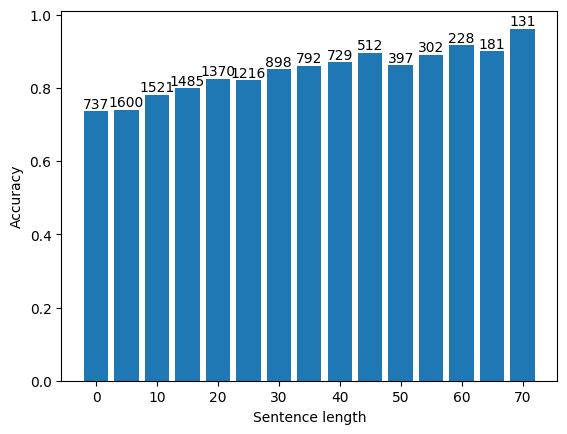

In [41]:
bar = plt.bar([x* 5 for x in list(bins.keys())][:15], list(bins.values())[:15], width=4)
plt.bar_label(bar,sizes[:15])

plt.xlabel("Sentence length")
plt.ylabel("Accuracy")

plt.savefig('bins_total.png')

plt.show()

In [3]:
import pandas as pd
predictions = pd.read_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/predictions_on_test.csv')

In [ ]:
predictions['tokenized_sent_len'] = predictions['sent'].apply(lambda x: len(tok.tokenize(x)))

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
np.mean(predictions['tokenized_sent_len'])

55.12657621707901

In [ ]:
np.mean(predictions['sent_len'])

27.843335993615323

# Analyze Model on Training Data

In [ ]:
# best_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/AI701/Classifying_Translationese/final_model_fr+en/checkpoint-316", return_dict=True)


In [ ]:
train_predictions = trainer.predict(train_dataset)
preds = np.argmax(train_predictions.predictions, axis=1)
print(classification_report(train_predictions.label_ids,preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10115
           1       0.98      0.99      0.99     10115

    accuracy                           0.98     20230
   macro avg       0.99      0.98      0.98     20230
weighted avg       0.99      0.98      0.98     20230



In [ ]:
train_predictions = pd.DataFrame({'sent': train_dataset.text, 'label': train_predictions.label_ids, 'pred': preds})

In [ ]:
train_predictions['source_lang'] = np.concatenate((['en'] * (2* len(ar_en_train)), ['fr'] * (2* len(ar_fr_train))), axis =0)

In [ ]:
train_predictions[train_predictions['label'] != train_predictions['pred']].to_csv('/content/drive/MyDrive/AI701/Classifying_Translationese/data/train_misclassifications.csv')